blah blah

In [69]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as truenp

import pandas as pd

from scipy.io import loadmat

from astropy.io import fits

from lowfsc.automate import flt_chop_seq

from lowfsc import props, control

from lowfsc.data import DesignData
from lowfsc.spectral import StellarDatabase, LOWFS_BANDPASS, ThroughputDatabase, mk_bandpass
from lowfsc.automate import evaluate_estimator_noise
from lowfsc.control import StateSpaceFilter

from lowfsc.emccd import EMCCD

from matplotlib import pyplot as plt

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from prysm.conf import config
from prysm.fttools import mdft
from prysm.mathops import np, fft, ndimage, special


import cupy as cp
from cupyx.scipy import (
    fft as cpfft,
    special as cpspecial,
    ndimage as cpndimage,
)

mdft.clear()
config.precision = 32
np._srcmodule = cp
fft._srcmodule = cpfft
ndimage._srcmodule = cpndimage
special._srcmodule = cpspecial

root = Path('~/src/lowfssim/data')
root = root.expanduser()

mas2nm = 2.87

plt.style.use('bmh')

wvl = mk_bandpass(5)
mode='hlc' # or spec or wfov

cam = EMCCD.cgi_camera()
wt = np.zeros(10)
mas2nm = 2.87

blah blah only makes sense in context of the ppt

## I: HLC Band 1 Sensing Noise vs V-mag

In [36]:
dd = DesignData.hlc_design(root)

# assume other parameters relatively unimportant / orthogonal to noise
# (not a very good assumption)
# dd = DesignData.contributed_dual_pcwfs(root, fpm_fov=2048)
dd.seed_zernikes(range(2,12))
zern_wts = np.zeros(10)

vmag_emgain_pairs = [
    [2.25, 100],
    [3, 200],
    [4, 400],
    [5, 1000],
    [6, 1000],
    [7, 1000],
    [8, 2000],
    [9, 2000],
    [10, 4000],
    [11, 4000],
    [12, 4000],
    [13, 5000],
]

chops = np.eye(10) * 5
gains = np.diag(chops)
ref_z = np.zeros(10)

vmag_sigma_pairs = []
ref_frame_sums = []

ref_star = (2.25, 'g0v', 100)
for vmag, emgain in vmag_emgain_pairs:
    targ_star = (vmag, 'g0v', emgain)
    d = flt_chop_seq(wvl, dd, ref_z, chops, gains, ref_star, targ_star, cam=cam, mode='hlc')
    Rtarg = d['R']
    wtarg = d['wtarg']
    
    cam.emgain = emgain
    
    fig2, sigmas = evaluate_estimator_noise(wvl, wtarg, cam, dd, Rtarg)
    plt.close(fig2)
    vmag_sigma_pairs.append((vmag, sigmas))
    ref_frame_sums.append(float(Rtarg.ref.sum()))

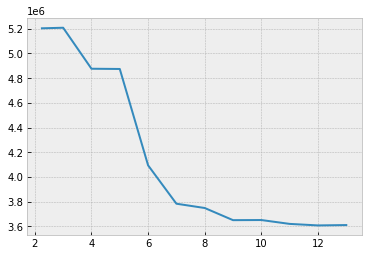

In [37]:
# typical ref_frame_sum when not shot noise dominated is ~ 3.75 x 1e6 for contributed
# for hlc band 1 design it is ~ 5 x 1e6
# => 33% more photons in the band 1 design
# but also very different spatial distribution
plt.plot(vmags, ref_frame_sums)

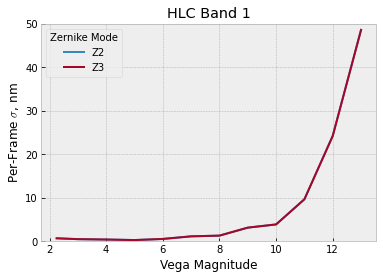

In [38]:
sigmas = [v[1] for v in vmag_sigma_pairs]
vmags = [v[0] for v in vmag_sigma_pairs]
sigmas = np.array(sigmas).get()
plt.plot(vmags, sigmas[:,1:3])
ax = plt.gca()
ax.set(ylim=(0,50), xlabel='Vega Magnitude', ylabel=r'Per-Frame $\sigma$, nm', title='HLC Band 1')
ax.legend(['Z2', 'Z3'], title='Zernike Mode')
plt.savefig('exep-hlc-band-1-sigma-vs-magnitude.png', dpi=200, bbox_inches='tight')

## II: Topology of Estimator Response

In [51]:
dd = DesignData.contributed_dual_pcwfs(root, fpm_fov=2048)
dd.seed_zernikes(range(2,12))

# make an estimator without noises in the system for clarity
d = flt_chop_seq(wvl, dd, ref_z, chops, gains, ref_star, targ_star, cam=cam, mode='hlc')
weights = d['wtarg']
R = d['R']

zwt = truenp.zeros(10, dtype=config.precision)
masx = truenp.linspace(-150,150,31)

out_z2 = []
out_z3 = []

for ptY in tqdm(masx):
    row_z2 = []
    row_z3 = []
    for ptX in masx:
        zwt[0] = ptX * mas2nm
        zwt[1] = ptY * mas2nm
        im = props.polychromatic(wvl, weights, dd, zernikes=zwt)
        est = R.estimate(im)
        row_z2.append(float(est[1]))
        row_z3.append(float(est[2]))
    
    out_z2.append(row_z2)
    out_z3.append(row_z3)

out_z2 = truenp.array(out_z2)
out_z3 = truenp.array(out_z3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


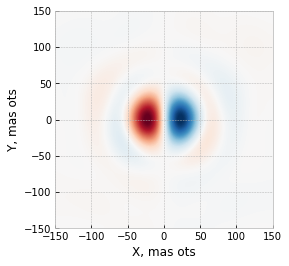

In [57]:
plt.imshow(out_z2/mas2nm, cmap='RdBu', interpolation='lanczos', extent=[-150,150,-150,150], origin='lower')
ax = plt.gca()
ax.set(xlabel='X, mas ots', ylabel='Y, mas ots')
plt.savefig('contributed-z2map.png', dpi=200, bbox_inches='tight')

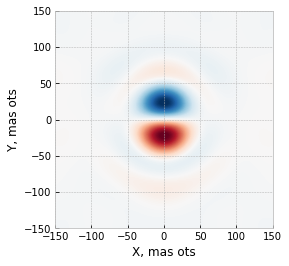

In [58]:
plt.imshow(out_z3/mas2nm, cmap='RdBu', interpolation='lanczos', extent=[-150,150,-150,150], origin='lower')
ax = plt.gca()
ax.set(xlabel='X, mas ots', ylabel='Y, mas ots')
plt.savefig('contributed-z3map.png', dpi=200, bbox_inches='tight')

## III: LOS capture vs V-mag

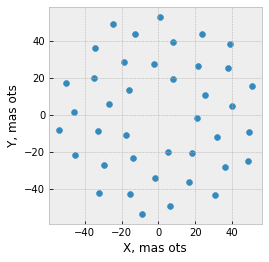

In [145]:
def pol2cart(r,t):
    x = r * truenp.cos(t)
    y = r * truenp.sin(t)
    return x, y
 
def chebygauss_quadrature_xy(rings, radius=1, spokes=-1, center=(0,0)):
    """Use Chebyshev-Gauss quadrature to sample a polar coordinate grid.
   
    Parameters
    ----------
    rings : `int`
        number of rings to use; degree of radial sampling
    radius : `float`
        radius of the grid, process units
    spokes : `int`, optional
        number of spokes if -1, use rings*2 + 1
    center : `tuple`
        (x,y) center point of the grid
   
    Returns
    -------
    `numpy.ndarray`
        Chebyshev-Gauss-Lobatto points (x,y)
   
    """
    # domain [0,1]
    a = 0
    b = 1
    if spokes == -1:
        spokes = 2*rings + 1
    n = rings
    r = [] # r = radial variable
    for k in range(1,n+1):
        num = 2*k - 1
        den = 2 * n
        term1 = 0.5 # 1/2 (a+b) == 0.5, fixed a,b
        # prefix to term2 also == term1
       
        # term2 == term1
        xk = term1 + term1 * truenp.cos((num/den) * truenp.pi)
        r.append(xk*radius)
        
    o_x = truenp.empty(spokes*len(r))
    o_y = truenp.empty(spokes*len(r))
    psi = (5 ** .5 + 1) / 2 # golden ratio
    lower = 0
    shift = spokes
    upper = shift
    for k, rr in enumerate(r):
        Delta = 2*truenp.pi / spokes
        # arange term = "j"
        # Greg forbes' theta = (j+k/psi)Delta; Delta = 2pi/J
        j = truenp.arange(1, spokes+1, dtype=np.float64)
        kk = k + 1
        t = (j + (kk/psi)) * Delta
        x, y = pol2cart(rr,t)
        o_x[lower:upper] = x
        o_y[lower:upper] = y
        upper += shift
        lower += shift
   
    return o_x, o_y

pt_x, pt_y = chebygauss_quadrature_xy(13, 55, spokes=5)
r = truenp.hypot(pt_x, pt_y)
mask = r > 20
pt_x = pt_x[mask]
pt_y = pt_y[mask]
pt_x = list(reversed(pt_x)) # start in the middle for aesthetic reasons, want to see a schmattering of success
pt_y = list(reversed(pt_y)) # before many failures
plt.scatter(pt_x, pt_y)
plt.gca().set(aspect='equal', xlabel='X, mas ots', ylabel='Y, mas ots')
plt.savefig('contributed-starting-point-art2.png', dpi=200, bbox_inches='tight')

In [72]:
# load controller ABCD and time series of disturbances
d = loadmat(root/'dynamics/dynamics_1khz_acsrwa.mat')
disturbances = d['disturbances']
d = loadmat(root/'dynamics/1khz_simplified_controller.mat')
A = truenp.squeeze(d['A'])
B = truenp.squeeze(d['B'])
C = truenp.squeeze(d['C'])
D = truenp.squeeze(d['D'])

[[1.         0.        ]
 [0.         0.55915836]]
[-0.26997285 -0.19721967]
[-0.29632609 -0.19721967]
0.06494653375425799


In [147]:
# this is taken essentially verbatim from analysis done for Roman-CGI baseline masks

def run_capture_study(weights, em_gain, disturbances, Rtarg, dd):
    logs = {
        'startx': [], # mas
        'starty': [], # mas
        'endx': [],   # mas
        'endy': [],   # mas
        'trajx': [],  # mas
        'trajy': [],  # mas
        'fbkx': [],   # nm
        'fbky': [],   # nm
        'estx': [],   # nm
        'esty': [],   # nm
        'tickstoclose': [],
        'closed': []
    }
    
    d = disturbances.T
    cam.em_gain = em_gain
    mas2nm = 2.87
    Z2ctl = StateSpaceFilter(A, B, C, D)
    Z3ctl = StateSpaceFilter(A, B, C, D)
    # for px, py in tqdm(zip(pt_x, pt_y)):
    cntr = 0
    wt_lcl = truenp.zeros(len(dd.zernNpup), dtype=config.precision)
#     for px, py in tqdm(zip(pt_x, pt_y), total=len(pt_x)):
    try:
        for px, py in zip(pt_x, pt_y):
            Z2ctl.x[:] = 0
            Z3ctl.x[:] = 0
            logs['startx'].append(px)
            logs['starty'].append(py)
            px = px * mas2nm
            py = py * mas2nm

            refx = px
            refy = py
            trajx = []
            trajy = []
            estx = []
            esty = []
            fbkx = []
            fbky = []
            z2fbk = 0
            z3fbk = 0
    #         for idx in range(10_000): # 10k samples = give up to 10s
            for idx in tqdm(range(10_000)):
                _, acsx, acsy, rwa = d[idx]
    #             acsx = acsx * mas2nm
    #             acsy = acsy * mas2nm
    #             rwa = rwa * mas2nm

                posx = refx + z2fbk + acsx + rwa
                posy = refy + z3fbk + acsy + rwa

                wt_lcl[0] = posx
                wt_lcl[1] = posy
                im = props.polychromatic(wvl, weights, dd, wt_lcl)
                im = cam.expose(im)
                est = Rtarg.estimate(im).get()
                z2 = est[1]
                z3 = est[2]
                z2fbk = Z2ctl.update(-z2)  # implicit: setpt = 0; arg is (setpt) - (meas)
                z3fbk = Z3ctl.update(-z3)

                fbkx.append(z2fbk/mas2nm)
                fbky.append(z3fbk/mas2nm)

                estx.append(z2/mas2nm)
                esty.append(z3/mas2nm)

                trajx.append(posx/mas2nm)
                trajy.append(posy/mas2nm)

                posr = truenp.hypot(posx, posy)
                if posr < 5*mas2nm:
                    break

                if posr > 500*mas2nm:
                    break

            endx = posx / mas2nm
            endy = posy / mas2nm
            logs['endx'].append(endx)
            logs['endy'].append(endy)
            logs['trajx'].append(trajx)
            logs['trajy'].append(trajy)
            logs['estx'].append(estx)
            logs['esty'].append(estx)
            logs['fbkx'].append(fbkx)
            logs['fbky'].append(fbky)
            logs['tickstoclose'].append(idx)
            logs['closed'].append(bool(posr < 5 * mas2nm))
            cntr += 1
    except KeyboardInterrupt:
        return logs

    return logs

In [135]:
dd = DesignData.contributed_dual_pcwfs(root, fpm_fov=2048)
dd.seed_zernikes(range(2,12))

d = flt_chop_seq(wvl, dd, ref_z, chops, gains, ref_star, ref_star, cam=cam, mode='hlc')
weights = d['wtarg']
R = d['R']

dd.seed_zernikes(range(2,4))

# check that we have everything self consistent before going ham
wts = truenp.zeros(2)
wts[1] = 5
im = props.polychromatic(wvl, weights, dd, zernikes=wts)
im = cam.expose(im, 10_000).mean(axis=0, dtype=config.precision)
R.estimate(im)[1]

array(-0.14092636, dtype=float32)

In [128]:
import json

In [ ]:
test_cases = [
    [9, 2000],
    [10, 4000],
    [11, 4000],
]

sns = (4,19)
sn4_valid_depths = [174, 190, 204, 214, 231, 241, 244]
sn19_valid_depths = [166, 175, 190, 204, 218, 229, 231]
valid_wavelengths = truenp.array([575-64, 575-32, 575, 575+32, 575+64])*1e-3
valid_depths = {
    4: sn4_valid_depths,
    19: sn19_valid_depths
}

for sn in sns:
    for depth in valid_depths[sn]:
        for test_case in test_cases:
#             print(f'{sn=} {depth=} {test_case=}')
            print(sn, depth, test_case)
            ref_star = (2.25, 'g0v', 100)
            targ_star = (test_case[0], 'g0v', test_case[1])
            dd = DesignData.contributed_dual_pcwfs(root, fpm_fov=2048, sn=sn, spot_depth=depth)
            dd.seed_zernikes(range(2,12))
            d = flt_chop_seq(wvl, dd, ref_z, chops, gains, ref_star, targ_star, cam=cam, mode='hlc')
            weights = d['wtarg']
            R = d['R']

            dd.seed_zernikes(range(2,4))

            logs = run_capture_study(weights,targ_star[2], disturbances, R, dd)
            with open(f'out-contributed/sn-{sn}_depth-{depth}_vmag-{test_case[0]}.json', 'w') as fid:
                json.dump(logs, fid)

4 174 [9, 2000]


  1%|▋                                                                                           | 70/10000 [00:01<04:34, 36.19it/s]


4 174 [10, 4000]


  1%|▋                                                                                           | 73/10000 [00:02<04:38, 35.65it/s]


4 174 [11, 4000]


  0%|▍                                                                                           | 43/10000 [00:01<04:42, 35.22it/s]


4 190 [9, 2000]


  1%|█▏                                                                                         | 137/10000 [00:03<04:37, 35.51it/s]


4 190 [10, 4000]


 87%|██████████████████████████████████████████████████████████████████████████████▏           | 8687/10000 [03:57<00:35, 36.54it/s]


4 190 [11, 4000]


  9%|███████▉                                                                                   | 869/10000 [00:24<04:13, 35.96it/s]


4 204 [9, 2000]


  1%|█                                                                                          | 114/10000 [00:03<04:40, 35.25it/s]


4 204 [10, 4000]


  1%|▊                                                                                           | 85/10000 [00:02<04:33, 36.29it/s]


4 204 [11, 4000]


 10%|█████████▎                                                                                | 1029/10000 [00:28<04:07, 36.22it/s]


4 214 [9, 2000]


 21%|██████████████████▊                                                                       | 2084/10000 [00:58<03:43, 35.37it/s]

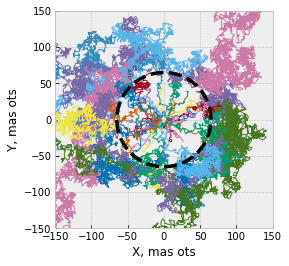

In [121]:
fig, ax = plt.subplots()
lowidx = 0
highidx = 559
for tx, ty in zip(logs['trajx'][lowidx:highidx], logs['trajy'][lowidx:highidx]):
# for tx, ty in zip(logs['estx'], logs['esty']):
    ax.plot(tx, ty, lw=1)

lim = 150

c = plt.Circle((0,0), radius=65, fill=False, ec='k', ls='--', zorder=5, lw=3.5)
ax.add_patch(c)
ax.set(aspect='equal',
       xlabel='X, mas ots', xlim=(-lim,lim),
       ylabel='Y, mas ots', ylim=(-lim,lim))

plt.savefig('contributed-sn4-depth-204-wide-annotate.png', dpi=200, bbox_inches='tight')

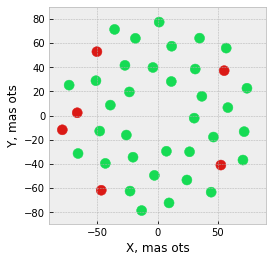

In [122]:
from matplotlib.colors import ListedColormap

lim = 90
fig, ax = plt.subplots()
cmap = ListedColormap(list(reversed(['#16DB54', '#DB1915'])))
ax.scatter(logs['startx'], logs['starty'], c=[bool(v) for v in logs['closed']], cmap=cmap, s=100, vmin=0, vmax=1)
ax.set(aspect='equal',
       xlabel='X, mas ots', xlim=(-lim,lim),
       ylabel='Y, mas ots', ylim=(-lim,lim))
# fig.colorbar(lb)

# savfn = matfn.replace('.mat', '-closing-map.png')
plt.savefig('contributed-first-trial-working-map.png', dpi=200, bbox_inches='tight')

In [152]:
for sn in sns:
    for depth in valid_depths[sn]:
        for test_case in test_cases:
            with open(f'out-contributed/sn-{sn}_depth-{depth}_vmag-{test_case[0]}.json', 'r') as fid:
                try:
                    logs = json.load(fid)

                    fig, ax = plt.subplots()
                    lowidx = 0
                    highidx = 559
                    for tx, ty in zip(logs['trajx'][lowidx:highidx], logs['trajy'][lowidx:highidx]):
                    # for tx, ty in zip(logs['estx'], logs['esty']):
                        ax.plot(tx, ty, lw=1)

                    lim = 150

                    c = plt.Circle((0,0), radius=65, fill=False, ec='k', ls='--', zorder=5, lw=3.5)
                    ax.add_patch(c)
                    ax.set(aspect='equal',
                           xlabel='X, mas ots', xlim=(-lim,lim),
                           ylabel='Y, mas ots', ylim=(-lim,lim))

                    plt.savefig(f'contributed-graphics/contributed-sn{sn}-depth-{depth}-{test_case}-wide.png', dpi=200, bbox_inches='tight')
                    plt.close(fig)
                except:
                    print(sn, depth, test_case)
                    continue

4 174 [9, 2000]


In [155]:
for sn in sns:
    for depth in valid_depths[sn]:
        for test_case in test_cases:
            with open(f'out-contributed/sn-{sn}_depth-{depth}_vmag-{test_case[0]}.json', 'r') as fid:
                try:
                    logs = json.load(fid)

                    lim = 70
                    fig, ax = plt.subplots()
                    ax.scatter(logs['startx'], logs['starty'], c=logs['closed'], cmap=cmap, s=100, vmin=0, vmax=1)
                    ax.set(aspect='equal',
                           xlabel='X, mas ots', xlim=(-lim,lim),
                           ylabel='Y, mas ots', ylim=(-lim,lim))
                    # fig.colorbar(lb)

                    # savfn = matfn.replace('.mat', '-closing-map.png')
                    plt.savefig(f'contributed-graphics/contributed-sn{sn}-depth-{depth}-{test_case}-working-map.png', dpi=200, bbox_inches='tight')
                    plt.close(fig)
                except:
                    print(sn, depth, test_case)
                    continue

4 174 [9, 2000]


In [166]:
for sn in sns:
    for depth in valid_depths[sn]:
        dd = DesignData.contributed_dual_pcwfs(root, fpm_fov=2048, sn=sn, spot_depth=depth)
        dd.seed_zernikes(range(2,12))

        d = flt_chop_seq(wvl, dd, ref_z, chops, gains, ref_star, ref_star, cam=None, mode='hlc')
        weights = d['wtarg']
        R = d['R']

        dd.seed_zernikes(range(2,4))

        # make an estimator without noises in the system for clarity

        zwt = truenp.zeros(2, dtype=config.precision)
        masx = truenp.linspace(-150,150,61)

        out_z2 = []
        out_z3 = []

        for ptY in tqdm(masx):
            row_z2 = []
            row_z3 = []
            for ptX in masx:
                zwt[0] = ptX * mas2nm
                zwt[1] = ptY * mas2nm
                im = props.polychromatic(wvl, weights, dd, zernikes=zwt)
                est = R.estimate(im)
                row_z2.append(float(est[1]))
                row_z3.append(float(est[2]))

            out_z2.append(row_z2)
            out_z3.append(row_z3)

        out_z2 = truenp.array(out_z2)
        out_z3 = truenp.array(out_z3)
        
        # Z2
        fig, ax = plt.subplots()
        im = ax.imshow(out_z2/mas2nm, cmap='RdBu', interpolation='lanczos', extent=[-150,150,-150,150], origin='lower', clim=(-5,5))
        plt.colorbar(im)
        ax.set(xlabel='X, mas ots', ylabel='Y, mas ots')
        plt.savefig(f'contributed-graphics/contributed-sn{sn}-depth-{depth}-morph-z2-tight.png', dpi=200, bbox_inches='tight')
        plt.close(fig)
        
        fig, ax = plt.subplots()
        im = ax.imshow(out_z2/mas2nm, cmap='RdBu', interpolation='lanczos', extent=[-150,150,-150,150], origin='lower', clim=(-20,20))
        plt.colorbar(im)
        ax.set(xlabel='X, mas ots', ylabel='Y, mas ots')
        plt.savefig(f'contributed-graphics/contributed-sn{sn}-depth-{depth}-morph-z2-loose.png', dpi=200, bbox_inches='tight')
        plt.close(fig)
        
        # Z3
        fig, ax = plt.subplots()
        im = ax.imshow(out_z3/mas2nm, cmap='RdBu', interpolation='lanczos', extent=[-150,150,-150,150], origin='lower', clim=(-5,5))
        plt.colorbar(im)
        ax.set(xlabel='X, mas ots', ylabel='Y, mas ots')
        plt.savefig(f'contributed-graphics/contributed-sn{sn}-depth-{depth}-morph-z3-tight.png', dpi=200, bbox_inches='tight')
        plt.close(fig)
        
        fig, ax = plt.subplots()
        im = ax.imshow(out_z3/mas2nm, cmap='RdBu', interpolation='lanczos', extent=[-150,150,-150,150], origin='lower', clim=(-20,20))
        plt.colorbar(im)
        ax.set(xlabel='X, mas ots', ylabel='Y, mas ots')
        plt.savefig(f'contributed-graphics/contributed-sn{sn}-depth-{depth}-morph-z3-loose.png', dpi=200, bbox_inches='tight')
        plt.close(fig)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [01:39<00:00,  1.63s/it]


[Text(0.5, 0, 'X, mas ots'), Text(0, 0.5, 'Y, mas ots')]

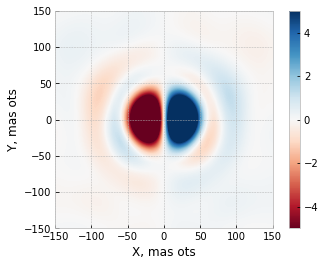

In [163]:
im = plt.imshow(out_z2/mas2nm, cmap='RdBu', interpolation='lanczos', extent=[-150,150,-150,150], origin='lower', clim=(-5,5))
plt.colorbar(im)
fig = plt.gcf()
ax = plt.gca()
ax.set(xlabel='X, mas ots', ylabel='Y, mas ots')